Note : This needs to be run for 20000 epochs for quality image and on a powerful GPU

**Research Paper : https://arxiv.org/pdf/1511.06434.pdf**

In [ ]:
#Importing the libraries

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import pandas as pd
import numpy as np
from numpy import zeros,ones,vstack
from numpy.random import randn
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from keras import backend as K
import random

In [ ]:
# load and prepare fashion mnist training images

def load_real_data():
  (x_train,_),(_,_) = tf.keras.datasets.fashion_mnist.load_data()
  x_train = x_train.astype('float32')/255.0
  x_train = np.reshape(x_train,(len(x_train),28,28,1))
  return x_train

In [ ]:
# select real samples from the loaded data

n_samples = 25

def generate_samples_real(x_train, n_samples):
  # converting x_train to list
  x_train = list(x_train)
  # retrieve selected images
  x_train = random.sample(x_train,n_samples)
  #converting list to numpy array
  x_train = np.array(x_train)
  # generate 'real' class labels (1)
  y = ones((n_samples, 1))
  return x_train, y

In [ ]:
# Creating a discriminator model

input_img = keras.Input(shape=(28,28,1))
layer_1 = layers.Conv2D(64,(3,3),strides = (2,2), padding='same',activation=tf.keras.layers.LeakyReLU(alpha=0.1))(input_img)
droput_1 = layers.Dropout(0.5)(layer_1)
layer_2 = layers.Conv2D(64,(3,3),strides = (2,2),padding='same',activation=tf.keras.layers.LeakyReLU(alpha=0.1))(droput_1)
dropout_2 = layers.Dropout(0.5)(layer_2)
flatten_layer = layers.Flatten()(dropout_2)
dense_out = layers.Dense(1,activation='sigmoid')(flatten_layer)

discriminator = keras.Model(input_img,dense_out,name='discriminator_model')
discriminator.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
plot_model(discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)
print(discriminator.summary())

Model: "discriminator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)         

In [ ]:
# defining the generator model

latent_dim = 100
n_nodes = 128 * 7 * 7

inp = keras.Input(shape=(latent_dim,),name='generator_input')
layer1 = layers.Dense(n_nodes)(inp)
reshape_1 = layers.Reshape((7,7,128))(layer1)
layer2 = layers.Conv2DTranspose(128, (4,4), strides=(2,2),padding='same',activation=tf.keras.layers.LeakyReLU(alpha=0.1))(reshape_1) #Upsampling to 14x14
layer3 = layers.Conv2DTranspose(128, (4,4), strides=(2,2),padding='same',activation=tf.keras.layers.LeakyReLU(alpha=0.1))(layer2) #Upsampling ton28x28
out_layer = layers.Conv2D(1,(7,7),activation='sigmoid',padding='same')(layer3)

generator = keras.Model(inp,out_layer,name = 'generator_model')
generator.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
plot_model(generator, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)
print(generator.summary())

Model: "generator_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 1)         6273      
Total params: 1,164,289
Trainable params: 1,164,289
Non-trainable params: 0
_________________________________________

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_model (Functional) (None, 28, 28, 1)         1164289   
_________________________________________________________________
discriminator_model (Functio (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


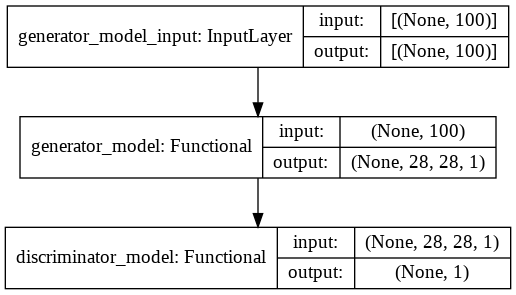

In [ ]:
gan_model = define_gan(generator,discriminator)
gan_model.summary()
plot_model(gan_model, to_file='ganmodel_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [ ]:
def train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=200, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_samples_real(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, discriminator_loss=%.3f, generator_loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
   # evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, generator, discriminator, dataset, latent_dim)

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_samples_real(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	generator.save(filename)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = discriminator
# create the generator
g_model = generator
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_data()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>179, 152/234, discriminator_loss=0.702, generator_loss=0.624
>179, 153/234, discriminator_loss=0.698, generator_loss=0.615
>179, 154/234, discriminator_loss=0.700, generator_loss=0.617
>179, 155/234, discriminator_loss=0.712, generator_loss=0.620
>179, 156/234, discriminator_loss=0.703, generator_loss=0.628
>179, 157/234, discriminator_loss=0.708, generator_loss=0.633
>179, 158/234, discriminator_loss=0.698, generator_loss=0.651
>179, 159/234, discriminator_loss=0.708, generator_loss=0.667
>179, 160/234, discriminator_loss=0.701, generator_loss=0.684
>179, 161/234, discriminator_loss=0.700, generator_loss=0.689
>179, 162/234, discriminator_loss=0.708, generator_loss=0.699
>179, 163/234, discriminator_loss=0.696, generator_loss=0.714
>179, 164/234, discriminator_loss=0.699, generator_loss=0.722
>179, 165/234, discriminator_loss=0.698, generator_loss=0.724
>179, 166/234, discriminator_loss=0.700, generator_loss=0.736
>179, 167/234, disc